In [2]:
#Instalación de Kaggle
!pip install -q kaggle

In [3]:
from google.colab import files
#subir kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erikamarlene","key":"2336a21daaa2f44411802d9434b732b3"}'}

In [4]:
#Configurar biblioteca de kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json #Colocamos el archivo en la carpeta
!chmod ~/.kaggle/kaggle.json 600 #Permiso 600 (lectura y escritura)

chmod: invalid mode: ‘/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


# Problemática
Decidí usar un dataset con imágenes de 525 diferentes especies de aves. Usando Convolutional Neural Network intentaré clasificar correctamente dichas imágenes de aves. El dataset se encuentra en https://www.kaggle.com/datasets/gpiosenka/100-bird-species
El data set contiene 525 especies. 84635 imagenes de entrenamiento , 2625 imagenes de test (5 imagenes por especies) y 2625 imagenes de validación (5 imagenes por especies)

In [5]:
# Descargar dataset
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:08<00:00, 295MB/s]
100% 1.96G/1.96G [00:08<00:00, 247MB/s]


In [6]:
#Unzip al archivo
!unzip 100-bird-species.zip -d '/content/kaggledb'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/132.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/133.j

## Preparando el dataset

Unifico las imágnes redimensionandolas y además selecciono un batch_size relativamente alto debido a la gran cantidad de imágenes que tiene el dataset. Separo las imágenes en train_dataset, test_dataset y validation_dataset.

In [7]:
import os
import pathlib
import tensorflow as tf
from keras.utils import image_dataset_from_directory


base_dir = pathlib.Path("./kaggledb")

# Obtener la lista de clases (nombres de las carpetas)
class_names = sorted([item.name for item in (base_dir / "train").glob('*')])
class_valid = sorted([item.name for item in (base_dir / "valid").glob('*')])

# Crear conjuntos de datos
# se selecciona un image_size para redimensionar
# todas las imágenes en el conjunto de datos
# y puedan ser procesadas de manera eficiente por el modelo.
# El batch_size es para indicar cuántas imágenes se utilizan
# en cada paso de entrenamiento.
train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=200,
    class_names=class_names,
    shuffle=True,
    seed=123
)

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=200,
    class_names=class_names,
    shuffle=True,
    seed=123
)
validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(180, 180),
    batch_size=200,
    class_names=class_valid,
    shuffle=True,
    seed=123
)



Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


Se hace un procesamiento para obtener etiquetas y además se convierte a formato one-hot encoding

In [8]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador de etiquetas
encoder = LabelEncoder()

# Codificar las etiquetas en formato numérico
y_train = encoder.fit_transform(train_dataset.class_names)
y_valid = encoder.fit_transform(validation_dataset.class_names)


In [9]:
from keras.utils import to_categorical

# Codificar las etiquetas en formato one-hot
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)


## Compilación y ejecución del modelo

El modelo consta de 9 capas:


*   La primera es una Capa de Convolución con 64 filtros, un kernel de 3x3 y
función de activación ReLU para introducir no linealidades en el modelo, permitiéndole aprender patrones más complejos.
* La segunda es una Capa de MaxPooling con un tamaño del pool (2x2). Esta capa reduce la dimensionalidad y el número de parámetros en el modelo. Ayuda a prevenir el sobreajuste.
* La tercera es otra Capa de Convolución pero con 128 filtros.
* La cuarta es otra Capa de MaxPooling.
* La quinta es otra Capa de Convolución pero con 256 filtros.
* La sexta es otra Capa de MaxPooling.
* La séptima es una Capa Flatten que transforma la salida 3D de las capas convolucionales y de agrupación en una forma plana 1D. Prepara los datos para las capas totalmente conectadas.
* La octava es una Capa Densa (Totalmente Conectada). Cuenta con 512 neuronas con una función de activación ReLU. Estas neuronas están conectadas a todas las neuronas de la capa anterior.
* La última capa es Densa (Totalmente Conectada). Es una capa de salida con 525 neuronas (ya que hay 525 clases), y utiliza una función de activación Softmax. Softmax asigna probabilidades a cada clase.


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pickle

# Define el modelo CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(525, activation='softmax')
])


In [ ]:
# Compila el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 256)       0

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

# Guardar el historial solo si no existe ya
historial_guardado = "historial_entrenamiento.pkl"
if not os.path.isfile(historial_guardado):
    with open(historial_guardado, 'wb') as f:
        pickle.dump(history.history, f)
# Verificar si el historial existe
if os.path.isfile(historial_guardado):
    print(f"El historial {historial_guardado} existe.")
else:
    print(f"El historial {historial_guardado} no existe.")

Epoch 1/10
424/424 [==============================] - 183s 427ms/step - loss: 5.4051 - accuracy: 0.0628 - val_loss: 5.3292 - val_accuracy: 0.0701
Epoch 2/10
424/424 [==============================] - 189s 443ms/step - loss: 4.6603 - accuracy: 0.1451 - val_loss: 5.5589 - val_accuracy: 0.0766
Epoch 3/10
424/424 [==============================] - 186s 436ms/step - loss: 3.8835 - accuracy: 0.2548 - val_loss: 6.2116 - val_accuracy: 0.0865
Epoch 4/10
424/424 [==============================] - 182s 427ms/step - loss: 3.2736 - accuracy: 0.3540 - val_loss: 7.2701 - val_accuracy: 0.0796
Epoch 5/10
424/424 [==============================] - 180s 421ms/step - loss: 2.6966 - accuracy: 0.4475 - val_loss: 8.7463 - val_accuracy: 0.0773
Epoch 6/10
424/424 [==============================] - 182s 426ms/step - loss: 2.2799 - accuracy: 0.5204 - val_loss: 10.2461 - val_accuracy: 0.0785
Epoch 7/10
424/424 [==============================] - 185s 434ms/step - loss: 1.9030 - accuracy: 0.5896 - val_loss: 10.8211

In [ ]:
# Evaluar el modelo
results = model.evaluate(test_dataset, verbose=0)
print(f'Test loss: {results[0]} / Test accuracy: {results[1]}')

# Guarda el modelo
model.save("bird_species_model.keras")

Test loss: 13.654425621032715 / Test accuracy: 0.095238097012043


In [ ]:
import pandas as pd
# Convertir resultados a df
df2 = pd.DataFrame(history.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,5.405096,0.062835,5.329165,0.070095
1,4.660320,0.145082,5.558925,0.076571
2,3.883506,0.254800,6.211646,0.086476
3,3.273590,0.353955,7.270060,0.079619
4,2.696574,0.447534,8.746303,0.077333
5,2.279936,0.520447,10.246106,0.078476
6,1.903039,0.589591,10.821127,0.083810
7,1.606887,0.645726,11.537941,0.077333
8,1.349430,0.695587,13.256241,0.073524
9,1.179958,0.730064,13.779194,0.083810


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

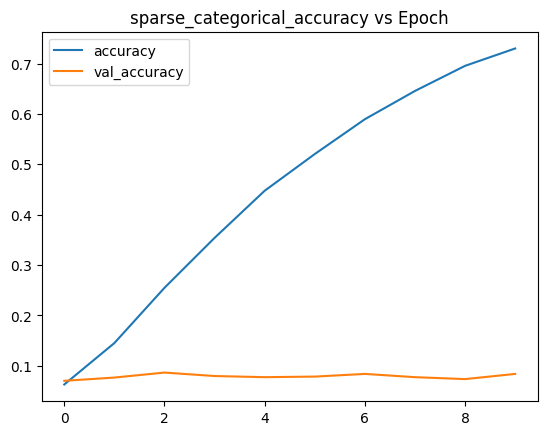

In [ ]:
# Gráfica de accuracy
df2.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

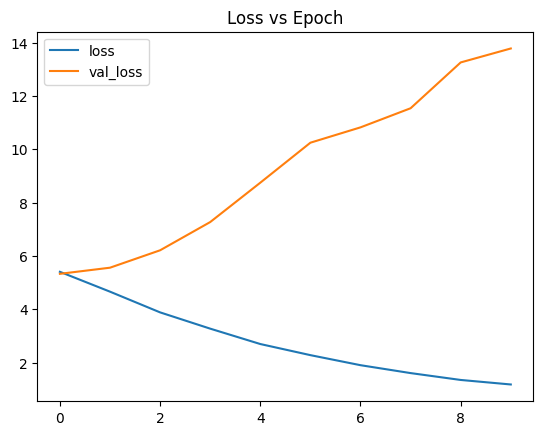

In [ ]:
# Gráfica de pérdida
df2.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

Los resultados obtenidos indican que el modelo tiene un rendimiento significativamente mejor en los datos de entrenamiento en comparación con los datos de validación y prueba.

La pérdida en los datos de entrenamiento (loss) es baja, lo que indica que el modelo se está ajustando bien a esos datos.
La precisión en los datos de entrenamiento (accuracy) es alta (alrededor del 73%).

La pérdida en los datos de validación es alta (alrededor de 13.78), lo que sugiere que el modelo no generaliza bien a nuevos datos. Este es un signo de posible sobreajuste.
La precisión en los datos de validación es baja (alrededor del 8.38%), lo cual es preocupante. Esto indica que el modelo no es capaz de generalizar bien a datos no vistos.

Estos resultados sugieren que el modelo está sobreajustando los datos de entrenamiento, lo que significa que se está adaptando demasiado a esos datos específicos y no generaliza bien a nuevos datos.

## Segundo modelo

Para este nuevo modelo agregué una capa de Dropout para evitar el overfitting. También agregué en la penúltima capa densa el regulador de l2. Esta penaliza los pesos de la red para evitar que se vuelvan muy grandes.

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2

# Modelo CNN con regularización Dropout
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.20),
    Dense(525, activation='softmax')
])

# Compila el modelo
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 256)       0

In [12]:
# Entrenamiento del modelo con más capas
history2 = model2.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)


Epoch 1/10
424/424 [==============================] - 196s 408ms/step - loss: 13.5448 - accuracy: 0.0177 - val_loss: 7.8977 - val_accuracy: 0.0453
Epoch 2/10
424/424 [==============================] - 179s 417ms/step - loss: 7.0091 - accuracy: 0.0605 - val_loss: 6.0366 - val_accuracy: 0.1261
Epoch 3/10
424/424 [==============================] - 180s 421ms/step - loss: 6.0399 - accuracy: 0.1413 - val_loss: 5.2354 - val_accuracy: 0.2168
Epoch 4/10
424/424 [==============================] - 181s 422ms/step - loss: 5.2718 - accuracy: 0.2420 - val_loss: 4.7677 - val_accuracy: 0.3158
Epoch 5/10
424/424 [==============================] - 182s 425ms/step - loss: 4.9024 - accuracy: 0.3073 - val_loss: 4.4397 - val_accuracy: 0.3870
Epoch 6/10
424/424 [==============================] - 192s 449ms/step - loss: 4.7672 - accuracy: 0.3496 - val_loss: 4.2342 - val_accuracy: 0.4469
Epoch 7/10
424/424 [==============================] - 178s 416ms/step - loss: 4.6673 - accuracy: 0.3821 - val_loss: 4.2924 

NameError: ignored

En los resultados obtenidos parece que se obtuvo un peor resultado 44% sin embargo con respecto a val_accuracy se muestra una mejor relación

In [13]:
# Guardar el historial solo si no existe ya
import pickle
import os
historial_guardado2 = "2historial_entrenamiento.pkl"
if not os.path.isfile(historial_guardado2):
    with open(historial_guardado2, 'wb') as f:
        pickle.dump(history2.history, f)
# Verificar si el historial existe
if os.path.isfile(historial_guardado2):
    print(f"El historial {historial_guardado2} existe.")
else:
    print(f"El historial {historial_guardado2} no existe.")

El historial 2historial_entrenamiento.pkl existe.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
historial_guardado2 = '/content/drive/MyDrive/2historial_entrenamiento.pkl'

In [16]:
if not os.path.isfile(historial_guardado2):
  with open(historial_guardado2, 'wb') as f:
        pickle.dump(history2.history, f)
# Verificar si el historial existe
if os.path.isfile(historial_guardado2):
    print(f"El historial {historial_guardado2} existe.")
else:
    print(f"El historial {historial_guardado2} no existe.")

El historial /content/drive/MyDrive/2historial_entrenamiento.pkl existe.


### Evaluación del modelo

In [17]:
# Evaluar el Segundo modelo
results2 = model2.evaluate(test_dataset, verbose=0)
print(f'Test loss: {results2[0]} / Test accuracy: {results2[1]}')

# Guarda el modelo
model2.save("bird_species_model2.keras")

Test loss: 4.013810634613037 / Test accuracy: 0.5375238060951233


Se puede observar que la precisión del test fue mucho mejor 53% a comparación de 09%

In [18]:
import pandas as pd
# Convertir resultados a df
dataframe = pd.DataFrame(history2.history)
dataframe

,loss,accuracy,val_loss,val_accuracy
0,13.544840,0.017664,7.897653,0.045333
1,7.009120,0.060507,6.036585,0.126095
2,6.039931,0.141277,5.235368,0.216762
3,5.271848,0.242004,4.767680,0.315810
4,4.902446,0.307343,4.439734,0.387048
5,4.767157,0.349584,4.234174,0.446857
6,4.667278,0.382052,4.292360,0.469333
7,4.578668,0.408176,4.188085,0.494476
8,4.507689,0.424127,4.235361,0.494476
9,4.496462,0.443115,4.197742,0.507810


A través de esta tabla que muestra los valores en las diferentes épocas se puede observar que si llegaramos a aumentarlas el desempeño sería mejor.  

<Axes: title={'center': '2º Modelo: sparse_categorical_accuracy vs Epoch'}>

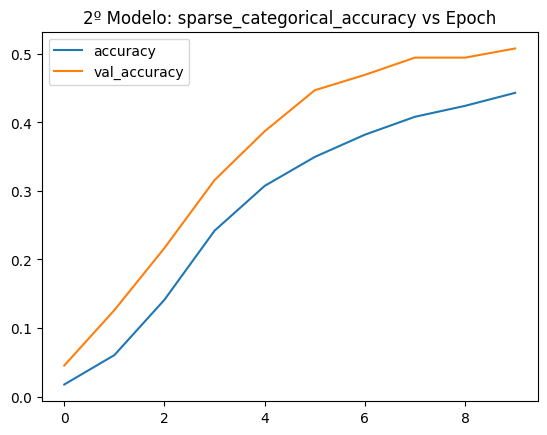

In [19]:
# Gráfica de accuracy
dataframe.plot(y=["accuracy", "val_accuracy"], title="2º Modelo: sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': '2º Modelo: Loss vs Epoch'}>

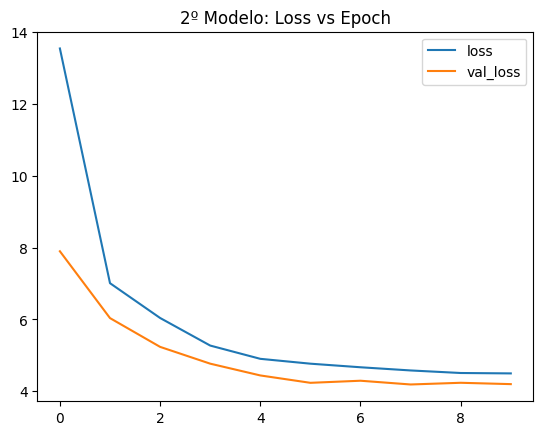

In [20]:
# Gráfica de pérdida
dataframe.plot(y=["loss", "val_loss"], title="2º Modelo: Loss vs Epoch")

Con ambas gráficas podemos observar como va aprendiendo de la mano

In [29]:
# Predicciones del modelo en el conjunto de prueba
y_pred = np.argmax(model2.predict(test_dataset), axis=1)

# Etiquetas reales del conjunto de prueba
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Índices donde las predicciones son diferentes de las etiquetas reales
indices_erroneos = np.where(y_pred != y_true)[0]

# Algunos de los índices erróneos
print("Índices de predicciones erróneas:", indices_erroneos[:30])


14/14 [==============================] - 4s 179ms/step
Índices de predicciones erróneas: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


14/14 [==============================] - 7s 241ms/step


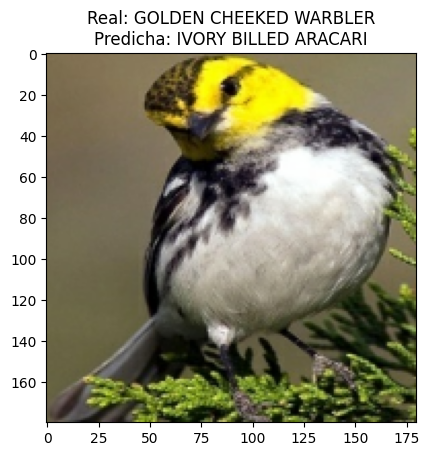

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener algunas predicciones
y_pred = model2.predict(test_dataset)

# Obtener etiquetas reales
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Obtener índices de predicciones incorrectas
indices_erroneos = np.where(np.argmax(y_pred, axis=1) != y_true)[0]

# Elegir aleatoriamente una predicción incorrecta
indice = np.random.choice(indices_erroneos)

# Obtener la imagen y las etiquetas correspondientes
imagen, etiqueta_real = test_dataset.take(1).as_numpy_iterator().next()  # Usar take para obtener una muestra
imagen = imagen[0]  # Desempaquetar la muestra
etiqueta_real = class_names[etiqueta_real[0]]

# Obtener la etiqueta predicha
etiqueta_predicha = class_names[np.argmax(y_pred[indice])]

# Ajustar la visualización para imágenes en el rango de 0 a 255
plt.imshow(imagen.astype("uint8"))
plt.title(f"Real: {etiqueta_real}\nPredicha: {etiqueta_predicha}")
plt.show()


Aquí podemos observar las especies de aves en las que el modelo se equivoca.

1/1 [==============================] - 0s 19ms/step


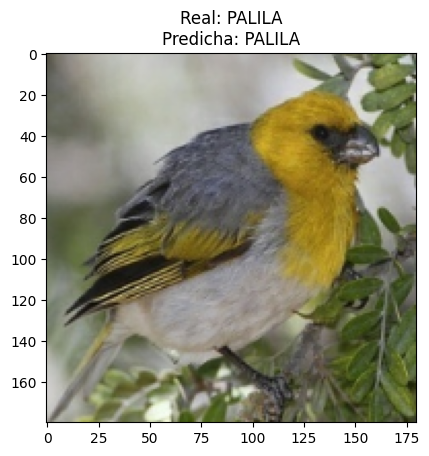

In [98]:
# Obtener índices de predicciones correctas
indices_correctos = np.where(np.argmax(y_pred, axis=1) == y_true)[0]

# Elegir aleatoriamente una predicción correcta
indice_correcto = np.random.choice(indices_correctos)

# Obtener la imagen y las etiquetas correspondientes
imagen_correcta, etiqueta_real_correcta = test_dataset.take(1).as_numpy_iterator().next()  # Usar take para obtener una muestra
imagen_correcta = imagen_correcta[0]  # Desempaquetar la muestra
etiqueta_real_correcta = class_names[etiqueta_real_correcta[0]]
# Obtener la etiqueta predicha para la imagen seleccionada
etiqueta_predicha_correcta = class_names[model2.predict(imagen_correcta.reshape(1, 180, 180, 3)).argmax()]

# Ajustar la visualización para imágenes en el rango de 0 a 255
plt.imshow(imagen_correcta.astype("uint8"))
plt.title(f"Real: {etiqueta_real_correcta}\nPredicha: {etiqueta_predicha_correcta}")
plt.show()


Ejemplo de una imagen en la que detecta su especie correcta.

## Conclusiones

Los modelos de CNN son buenos para clasificar imágenes. Aprendí sobre las diferentes capas que se pueden aplicar. Sin embargo sigue siendo confuso saber cuales elegir para que el modelo mejore a grandes razgos. Se me hace complicado entrenar los modelos debido a que gastan mucha memoria y toma demasiado tiempo. Sé que se necesita probar de diferentes capas, parámetros, etc. pero es muy difícil con las limitantes de Google Colab